# Preprocessing

In [1]:
import os
#os.environ['PYTHONHASHSEED'] = '0'

import tensorflow as tf
#tf.random.set_seed(89)

import numpy as np
#np.random.seed(42)

import random as rn
#rn.seed(1254)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%%capture
!unzip -o "/content/drive/My Drive/Thesis/deepfake-detection-master/ff_dataset.zip" -d /content/

## Parameters

In [4]:
BATCH_SIZE = 32
SIZE = 224
EPOCHS = 50

input_shape = (SIZE, SIZE, 3)
learning_rate = 0.0002
dl_rate = 1

## Store into tf.data.Dataset

### FaceForensics++

In [5]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

dir_train = os.path.join('ff_dataset', 'Frames_train')
dir_val = os.path.join('ff_dataset', 'Frames_validation')
dir_test = os.path.join('ff_dataset', 'Frames_test')
image_format = '.jpg'

training_dataset = image_dataset_from_directory(
    dir_train,
    labels="inferred",
    label_mode="binary",
    class_names=['df', 'real'],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(SIZE, SIZE),
    shuffle=True,
    seed=42
)

validation_dataset = image_dataset_from_directory(
    dir_val,
    labels="inferred",
    label_mode="binary",
    class_names=['df', 'real'],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(SIZE, SIZE),
    shuffle=True,
    seed=42
)


Found 46402 files belonging to 2 classes.
Found 15407 files belonging to 2 classes.


# Model

XceptionNet [14] is a traditional CNN trained on ImageNet based on separable convolutions with residual connections. We transfer it to our task by replacing the final
fully connected layer with two outputs. The other layers are
initialized with the ImageNet weights. To set up the newly
inserted fully connected layer, we fix all weights up to the final layers and pre-train the network for 3 epochs. After this
step, we train the network for 15 more epochs and choose
the best performing model based on validation accuracy.

## Callbacks

In [6]:
from tensorflow import keras

# This function keeps the initial learning rate for the first ten epochs  
# and decreases it exponentially after that.  
def scheduler(epoch):
    lr = 1e-3
    if epoch < 10:
        lr = 0.005 
    if epoch >= 10 and epoch< 20:
        lr = 0.001 
    elif epoch >= 20 and epoch < 30:
        lr = 0.001
    elif epoch >= 30 and epoch < 40:
        lr = 0.0001
    elif epoch >= 40:
        lr = 0.0001
    print("{0:.8f}".format(lr))
    return lr

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_binary_accuracy",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

## Compile Model

In [7]:
''' Instantiate a base model with pre-trained weights. '''
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=input_shape,
    include_top=False)  # Do not include the ImageNet classifier at the top.

''' Then, freeze the base model. '''
base_model.trainable = False

''' Create a new model on top. '''
inputs = keras.Input(shape=input_shape)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# A Dense classifier with a single unit (binary classification)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

''' Compile model '''
model.compile(
    optimizer=keras.optimizers.Adam(lr = learning_rate),  # Low learning rate
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


# Training

XceptionNet [14]-
based approach is trained with a learning-rate of 0:0002 and
a batch-size of 32. All detection methods are trained with
the Adam optimizer using the default values for the moments (β1 = 0:9, β2 = 0:999,  = 10−8).
We compute validation accuracies ten times per epoch
and stop the training process if the validation accuracy does
not change for 10 consecutive checks. Validation and test
accuracies are computed on 100 images per video, training
is evaluated on 270 images per video to account for frame
count imbalance in our videos. Finally, we solve the imbalance between real and fake images in the binary task (i.e.,
the number of fake images being roughly four times as large
as the number of pristine images) by weighing the training
images correspondingly.

## Train the top layer

In [8]:
history = model.fit(training_dataset,
                    epochs=3,
                    validation_data=validation_dataset,
                    callbacks=[early_stopping],
                    workers=4)


Epoch 1/3
1451/1451 [==============================] - 315s 214ms/step - loss: 24.1939 - binary_accuracy: 0.4955 - val_loss: 2.5222 - val_binary_accuracy: 0.5541
Epoch 2/3
1451/1451 [==============================] - 316s 218ms/step - loss: 2.2050 - binary_accuracy: 0.5327 - val_loss: 1.5259 - val_binary_accuracy: 0.5583
Epoch 3/3
1451/1451 [==============================] - 316s 218ms/step - loss: 1.3193 - binary_accuracy: 0.5492 - val_loss: 1.0179 - val_binary_accuracy: 0.5790


## Training and Validation Graphs

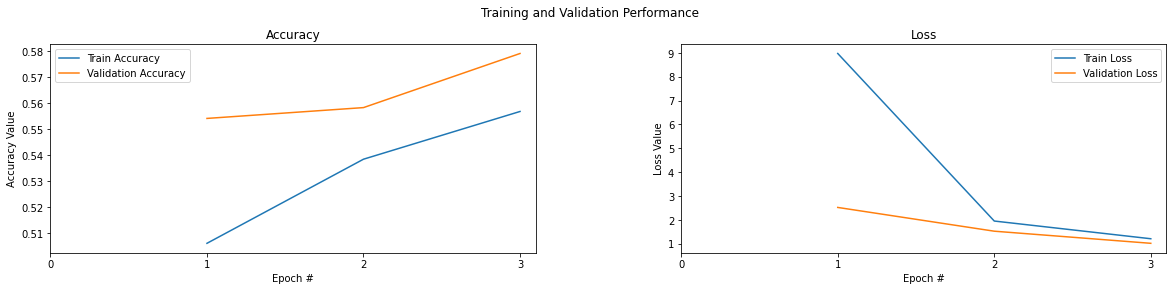

In [10]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Training and Validation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,3+1))
ax1.plot(epoch_list, history.history['binary_accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_binary_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 3+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 3+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Do a round of fine-tuning of the entire model

Finally, let's unfreeze the base model and train the entire model end-to-end with a low learning rate.

Importantly, although the base model becomes trainable, it is still running in inference mode since we passed training=False when calling it when we built the model. This means that the batch normalization layers inside won't update their batch statistics. If they did, they would wreck havoc on the representations learned by the model so far.

In [11]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(lr = learning_rate),  # Low learning rate
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_________________________________________________________________


In [12]:
history = model.fit(training_dataset,
                    epochs=15,
                    validation_data=validation_dataset,
                    callbacks=[early_stopping],
                    workers=4)

Epoch 1/15
1451/1451 [==============================] - 1038s 713ms/step - loss: 176.5786 - binary_accuracy: 0.6776 - val_loss: 0.2804 - val_binary_accuracy: 0.6073
Epoch 2/15
1451/1451 [==============================] - 1010s 696ms/step - loss: 0.1038 - binary_accuracy: 0.8735 - val_loss: 0.1522 - val_binary_accuracy: 0.7844
Epoch 3/15
1451/1451 [==============================] - 1011s 697ms/step - loss: 0.0587 - binary_accuracy: 0.9488 - val_loss: 0.1928 - val_binary_accuracy: 0.7334
Epoch 4/15
1451/1451 [==============================] - 1036s 714ms/step - loss: 0.0434 - binary_accuracy: 0.9689 - val_loss: 0.1472 - val_binary_accuracy: 0.7991
Epoch 5/15
1451/1451 [==============================] - 1011s 697ms/step - loss: 0.0305 - binary_accuracy: 0.9814 - val_loss: 0.1996 - val_binary_accuracy: 0.7345
Epoch 6/15
1451/1451 [==============================] - 1014s 699ms/step - loss: 0.0364 - binary_accuracy: 0.9687 - val_loss: 0.1344 - val_binary_accuracy: 0.8249
Epoch 7/15
1451/1451

## Training and Validation Graphs

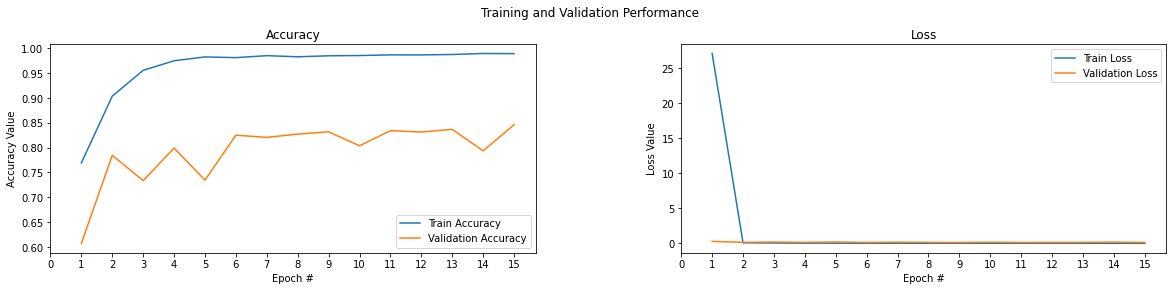

In [14]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Training and Validation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,15+1))
ax1.plot(epoch_list, history.history['binary_accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_binary_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 15+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 15+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Prediction

## Store into tf.data.Dataset

In [15]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

dir_train = os.path.join('ff_dataset', 'Frames_train')
dir_val = os.path.join('ff_dataset', 'Frames_validation')
dir_test = os.path.join('ff_dataset', 'Frames_test')
image_format = '.jpg'

test_dataset = image_dataset_from_directory(
    dir_test,
    labels="inferred",
    label_mode="binary",
    class_names=['fake', 'real'],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(SIZE, SIZE),
    shuffle=False,
)


Found 15667 files belonging to 2 classes.


## Make Prediction

In [16]:
Y_pred = (model.predict(test_dataset, verbose=1) > 0.5).astype("int32")

490/490 [==============================] - 76s 153ms/step


### Read Original Labels

In [17]:
Y_test = []
for img_array, label in (test_dataset.as_numpy_iterator()):
    Y_test.append(label)

### Flatten Original and Prediction label arrays

In [18]:
original_labels = []
original_labels = list(np.concatenate(Y_test).flat)
original_labels = np.array(original_labels)

predicted_labels = []
predicted_labels = list(np.concatenate(Y_pred).flat)
predicted_labels = np.array(predicted_labels)

## Classification Report

In [21]:
from sklearn.metrics import classification_report
classificationReport = classification_report(original_labels, predicted_labels, target_names=test_dataset.class_names, digits=5)
print(classificationReport)

              precision    recall  f1-score   support

        fake    0.87905   0.75748   0.81375      7983
        real    0.77970   0.89172   0.83196      7684

    accuracy                        0.82332     15667
   macro avg    0.82938   0.82460   0.82286     15667
weighted avg    0.83032   0.82332   0.82268     15667



## Confusion Matrix

True positive =  6047
False positive =  1936
False negative =  832
True negative =  6852




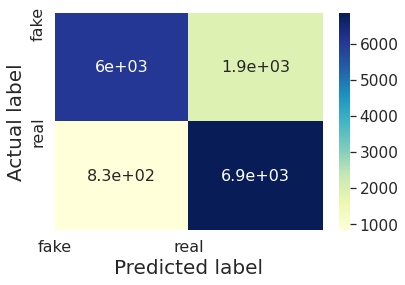

In [22]:
#Output confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu") # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), test_dataset.class_names, size = 16)
    plt.yticks(np.arange(2), test_dataset.class_names, size = 16)
    plt.ylim([2, 0])
    plt.show()
    return cm
    
confusionMatrix = print_confusion_matrix(original_labels, predicted_labels)

# Write to File

In [24]:
import os

tp = str('True positive = '+ str(confusionMatrix[0][0]) + '\n')
fp = str('False positive = '+ str(confusionMatrix[0][1]) + '\n')
fn = str('False negative = '+ str(confusionMatrix[1][0]) + '\n')
tn = str('True negative = '+ str(confusionMatrix[1][1]) + '\n')

data = (
    'Model Name: ' + 'XceptionNet' + '\n' +
    'Batch Size: ' + str(BATCH_SIZE) + '\n' +
    'Image Size: ' + str(SIZE) + '\n' +
    'Epochs: ' + str(EPOCHS) + '\n' +
    '===================================================== \n\n' +
    str(classificationReport) + '\n' + str(tp + fp + fn + tn)
)

from datetime import datetime 
import pytz 
  
# get the standard UTC time  
UTC = pytz.utc 
  
# it will get the time zone  
# of the specified location 
IST = pytz.timezone('Asia/Kolkata') 
  
datetime_ist = datetime.now(IST) 
filename = ('Report ' + datetime_ist.strftime('%Y-%m-%d %H%M') + ' Xception' + '.txt')

myFile = open(filename, 'w')
myFile.write(data)
myFile.close()

model.save('Xception ' + datetime_ist.strftime('%Y-%m-%d %H%M') + '.h5')